In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import nb_utils
import n_sphere

/store/CIA/js2164/conda_envs/score_sde/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Moving cwd to /store/CIA/js2164/repos/diffusion/score_sde_pytorch


In [5]:
from utils import generate_grid, extract_vector_field, compute_curl
from itertools import product
n = 50
d=1.5
x_grid = np.linspace(-d,d,20)
y_grid = np.linspace(-d,d,20)    
grid = np.array(list(product(x_grid, y_grid)))
grid.shape
#grid = np.cat(grid)

(400, 2)

In [6]:
from scipy.special import ive
def von_mises_grad_log(p,k):
    return - ive(p/2, k) / ive(p/2-1, k)

In [7]:
def score(x, sigma=1):
    r = np.linalg.norm(x)
    return (-von_mises_grad_log(2, r/sigma**2) - r) / sigma **2


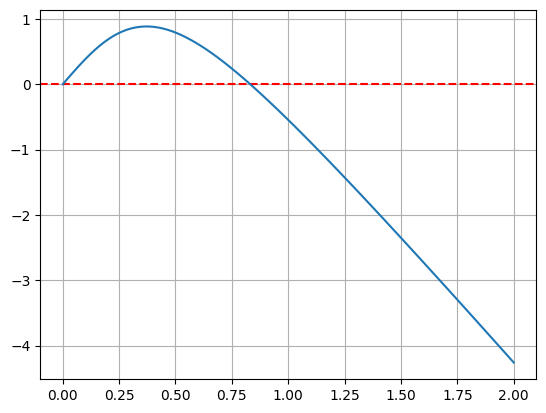

In [15]:
sigma=0.5
x = np.linspace(0, 2, 100)
s=[score(np.array([0,r]), sigma) for r in x]
plt.axhline(y=0, color='r', linestyle='--')
plt.plot(x, s)
plt.grid(True)
plt.show()

In [10]:
vectors = np.stack([score(x, sigma=sigma) * (x / np.linalg.norm(x)) for x in grid])
vectors.shape

(400, 2)

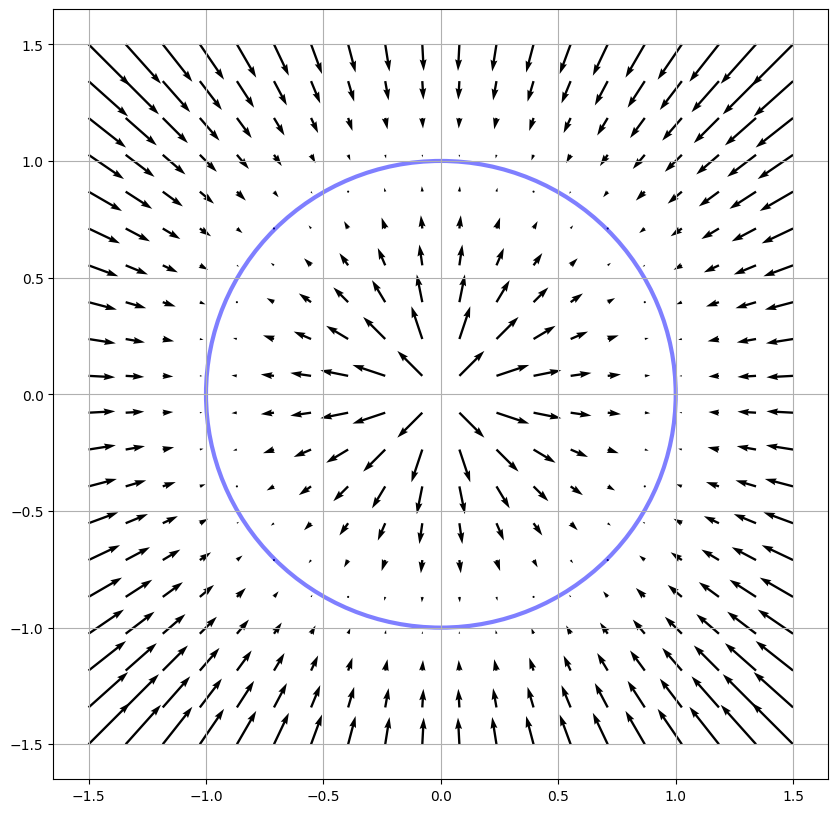

In [11]:
plt.figure(figsize=(10, 10))
plt.quiver(grid[:,0], grid[:,1], vectors[:,0], vectors[:,1])
circle1 = plt.Circle((0, 0), 1, color='b', fill=False, linewidth=3.0, alpha=0.5)
#ircle2 = plt.Circle((0, 0), 0.5, color='b', fill=False, linewidth=3.0, alpha=0.5)
plt.gca().add_patch(circle1)
#plt.gca().add_patch(circle2)
plt.grid()
#plt.axis('off')

In [5]:
from configs.utils import read_config
config = read_config('configs/ksphere/N_1/uniform_10_GT.py')

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.KSphereGroundTruthModel import KSphereGroundTruthModel
from models.ksphere_gt import KSphereGT
from models.ddpm import DDPM
import pickle
import sde_lib

def sample(config):
    from sampling.unconditional import get_sampling_fn
    ckpt_path = config.model.checkpoint_path
    pl_module = KSphereGroundTruthModel.load_from_checkpoint(ckpt_path)
    pl_module.to(config.device)
    score_model = pl_module.score_model
    pl_module.configure_sde(config)
    pl_module = pl_module.eval()

    num_samples = 100  
    sde = sde_lib.VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales, data_mean=None) #pl_module.sde
    sampling_eps = 1e-5
    sampling_shape = [num_samples] +  config.data.shape
    sampling_fn = get_sampling_fn(config, sde, sampling_shape, sampling_eps)
    score_model = pl_module.score_model
    samples, _ = sampling_fn(score_model)#, show_evolution=False)
    return samples

In [27]:
config.model.checkpoint_path = 'test_logs/uniform_GT6738a5fc-ad85-44d9-a279-3f638c36bf2c/checkpoints/best/last.ckpt'
samples = sample(config)

100%|██████████| 1000/1000 [00:02<00:00, 334.50it/s]


In [28]:
torch.linalg.norm(samples, dim=1)

tensor([1.0286, 1.0249, 1.0213, 1.0000, 1.0341, 1.0213, 1.0237, 1.0165, 1.0163,
        1.0111, 1.0319, 1.0422, 1.0227, 1.0187, 1.0275, 1.0215, 1.0253, 1.0298,
        1.0221, 1.0311, 1.0321, 1.0306, 1.0192, 1.0055, 1.0340, 1.0296, 1.0291,
        1.0280, 1.0243, 1.0455, 1.0147, 1.0361, 1.0214, 1.0253, 1.0173, 1.0209,
        1.0229, 1.0108, 1.0257, 1.0219, 1.0160, 1.0116, 1.0231, 1.0253, 1.0116,
        1.0176, 1.0100, 1.0332, 1.0298, 1.0127, 1.0169, 1.0272, 1.0336, 1.0339,
        1.0037, 1.0178, 1.0356, 1.0417, 1.0165, 1.0174, 1.0334, 1.0383, 1.0337,
        1.0270, 1.0198, 1.0380, 1.0245, 1.0305, 1.0196, 1.0347, 1.0326, 1.0193,
        1.0295, 1.0286, 1.0271, 1.0300, 1.0128, 1.0210, 1.0316, 1.0140, 1.0192,
        1.0362, 1.0250, 1.0232, 1.0084, 1.0269, 1.0322, 1.0184, 1.0339, 1.0097,
        1.0147, 1.0201, 1.0376, 1.0293, 1.0117, 1.0346, 1.0173, 1.0341, 1.0257,
        1.0175], device='cuda:0')

In [29]:
from lightning_data_modules import HaarDecomposedDataset, ImageDatasets, PairedDataset, SyntheticDataset, SyntheticPairedDataset, Synthetic1DConditionalDataset, SyntheticTimeSeries, SRDataset, SRFLOWDataset, KSphereDataset, MammothDataset, LineDataset, GanDataset #needed for datamodule registration
from dim_reduction import get_manifold_dimension
config.training.batch_size=32
config.dim_estimation.num_datapoints=5
get_manifold_dimension(config)

 80%|████████  | 4/5 [00:00<00:00,  9.86it/s]


In [30]:
path = 'logs/ksphere/n_1/dim_10/random_isometry/uniform_GT/svd/svd.pkl'
with open(path, 'rb') as f:
    svd = pickle.load(f)
singular_values = svd['singular_values']

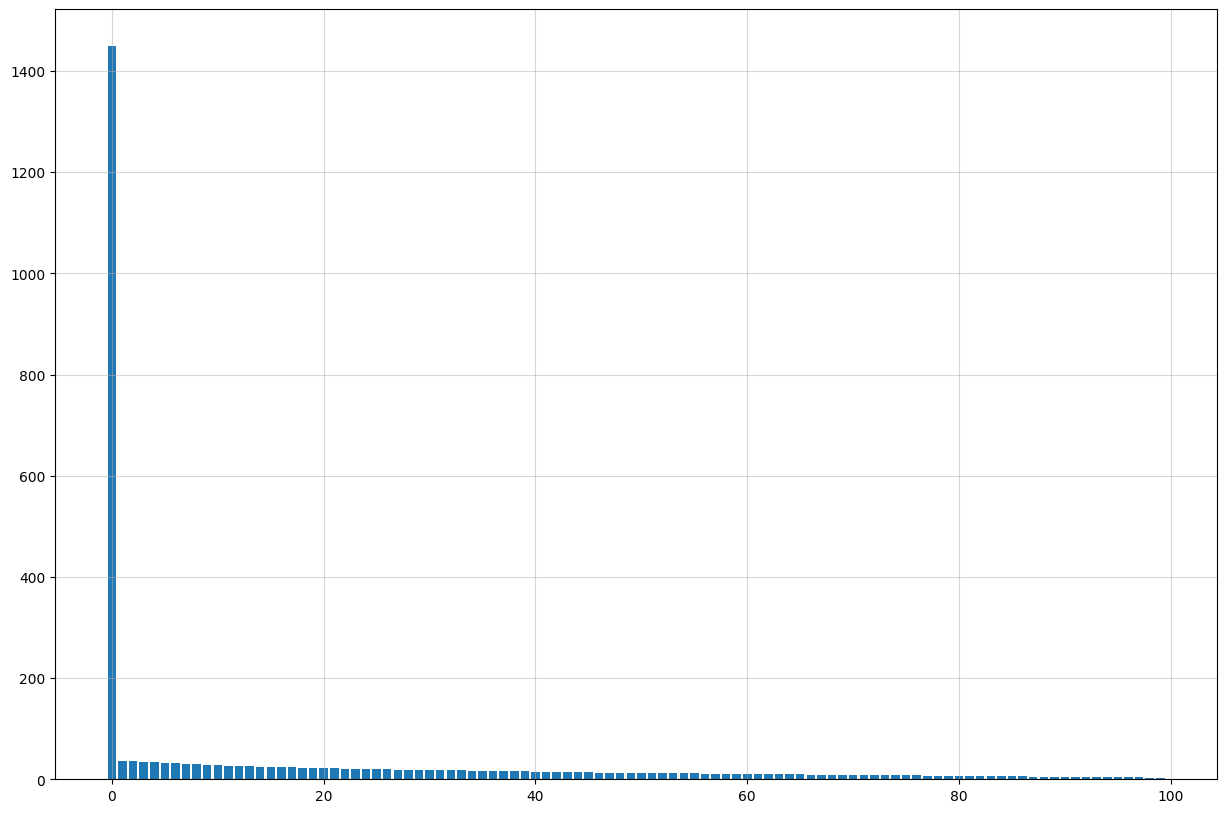

In [31]:
s = singular_values[0]
fig = plt.figure(figsize=(15,10))
#ax.rcParams.update({'font.size': 16})
plt.grid(alpha=0.5)
plt.bar(range(len(s)), s)
#plt.xticks(range(0, 100, 5))
#plt.vlines(95, 0, np.max(s), color='r', linestyles='--')
#plt.vlines(70, 0, np.max(s), color='r', linestyles='--')
fig.show()

In [23]:
singular_values

[[1135.345703125,
  40.997840881347656,
  30.29530143737793,
  29.807212829589844,
  28.425596237182617,
  28.147768020629883,
  27.137569427490234,
  25.238283157348633,
  24.187746047973633,
  23.612781524658203,
  22.971513748168945,
  22.550682067871094,
  21.390348434448242,
  20.858667373657227,
  20.272993087768555,
  19.543087005615234,
  19.08269500732422,
  18.517269134521484,
  17.924501419067383,
  17.47990608215332,
  17.153108596801758,
  16.649688720703125,
  16.390575408935547,
  15.974609375,
  15.151634216308594,
  14.965964317321777,
  14.493128776550293,
  14.078792572021484,
  13.74238395690918,
  13.199695587158203,
  12.791786193847656,
  12.417609214782715,
  12.219828605651855,
  11.76598834991455,
  11.476030349731445,
  11.233733177185059,
  11.122941017150879,
  10.506786346435547,
  10.283699989318848,
  9.99951171875,
  9.837170600891113,
  9.30052375793457,
  9.151453018188477,
  9.003388404846191,
  8.551253318786621,
  8.34227180480957,
  8.115853309631